In [1]:
import itertools as it

from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: b93c6e5be52c
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 2
nbname: reconstructed-tree-phylometrics
nbpath: /opt/hstrat-evolutionary-inference/binder/reconstructed-tree-phylometrics.ipynb
revision: null
session: 03600ee6-20d3-4040-918e-adfc79199de1
timestamp: 2023-03-12T07:35:21Z00:00


IPython==7.16.1
keyname==0.5.2
yaml==6.0
matplotlib==3.5.3
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
seaborn==0.12.2
teeplot==0.2.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.0.3
json==2.0.9
six==1.16.0
ipykernel==5.5.3


In [3]:
df = pd.read_csv("https://osf.io/5trmg/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


3b0245309571602d


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,14,...,222245.143375,10.507880,0,24568,1222.888975,3.172174e+06,216613.033012,NaN,NaN,NaN
1,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,48,...,229130.407979,13.872127,0,27597,1218.312041,3.318682e+06,651239.465532,NaN,NaN,NaN
2,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,3,...,284849.005921,11.622811,0,25234,1211.424603,3.052790e+06,514176.080681,NaN,NaN,NaN
3,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,10,...,188583.333771,9.209171,0,25388,1292.644315,3.547016e+06,497751.272393,NaN,NaN,NaN
4,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,18,...,275538.079227,12.278440,0,24122,1293.437720,3.312494e+06,518201.905151,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85795,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,0,...,17.635489,17.635489,1,3036,170.558104,5.577250e+04,6234.641599,30.0,0.01,naive
85796,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,42,...,21.165177,21.165177,1,436594,2.072540,6.791300e+04,0.493756,3.0,1.00,rollback
85797,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,45,...,36.573624,36.573624,1,492068,3.755694,1.230666e+05,0.658304,10.0,1.00,expected
85798,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,4,...,36.416021,36.416021,1,3774,123.845566,4.049750e+04,2327.128776,30.0,0.01,rollback


In [4]:
# phylometrics whittled down to descriptive, non-redundant set
phylometrics = [
    #     'diversity',
    "colless_like_index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean_pairwise_distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean_evolutionary_distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [5]:
methodological_variables = [
    "resolution",
]


In [6]:
evolutionary_variables = [
    "num_islands",
    "num_niches",
    "tournament_size",
]


In [7]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [8]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "p_niche_invasion",  # only use 3.0517578125e-08
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
]


In [9]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & (df["p_niche_invasion"] == 3.0517578125e-08)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1, excluded_variable

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,14,...,222245.143375,10.507880,0,24568,1222.888975,3172174.0,216613.033012,NaN,NaN,NaN
1,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,48,...,229130.407979,13.872127,0,27597,1218.312041,3318682.0,651239.465532,NaN,NaN,NaN
2,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,3,...,284849.005921,11.622811,0,25234,1211.424603,3052790.0,514176.080681,NaN,NaN,NaN
3,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,10,...,188583.333771,9.209171,0,25388,1292.644315,3547016.0,497751.272393,NaN,NaN,NaN
4,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,18,...,275538.079227,12.278440,0,24122,1293.437720,3312494.0,518201.905151,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85774,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,23,...,24.538727,24.538727,1,490688,5.000229,163847.5,4.406993,3.0,1.0,naive
85782,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,2,...,44.395594,44.395594,1,531415,2.696777,88368.0,0.634871,100.0,1.0,naive
85785,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,45,...,24.632432,24.632432,1,431534,3.612518,118375.0,0.679514,3.0,1.0,naive
85786,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,6,...,25.068072,25.068072,1,468138,3.727798,122152.5,3.471794,3.0,1.0,naive


In [10]:
# exclude extraneous variable values
df = df[(df["a"] != "consolidated-phylogeny")].copy()

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
300,reconstructed-tree,7,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,31,...,19.400293,19.400293,0,534071,113.968277,3734512.5,2044.180574,30.0,1.0,naive
303,reconstructed-tree,7,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,45,...,17.592952,17.592952,0,483414,118.163651,3871986.5,4409.976736,3.0,1.0,naive
305,reconstructed-tree,7,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,11,...,22.991331,22.991331,0,531785,119.747513,3923886.5,9957.713723,10.0,1.0,naive
307,reconstructed-tree,7,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,3,...,24.570888,24.570888,0,576970,122.424622,4011610.0,8435.151351,30.0,1.0,naive
310,reconstructed-tree,7,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,17,...,21.007820,21.007820,0,539541,104.064102,3409972.5,4141.574933,10.0,1.0,naive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85774,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,23,...,24.538727,24.538727,1,490688,5.000229,163847.5,4.406993,3.0,1.0,naive
85782,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,2,...,44.395594,44.395594,1,531415,2.696777,88368.0,0.634871,100.0,1.0,naive
85785,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,45,...,24.632432,24.632432,1,431534,3.612518,118375.0,0.679514,3.0,1.0,naive
85786,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,6,...,25.068072,25.068072,1,468138,3.727798,122152.5,3.471794,3.0,1.0,naive


In [11]:
df["num_niches"].unique()


array([4, 8, 1])

In [12]:
df["num_islands"].unique()


array([1024,    1])

In [13]:
df["tournament_size"].unique()


array([2, 8])

In [14]:
df["a"].unique()


array(['reconstructed-tree', 'collapsed-phylogeny'], dtype=object)

In [15]:
df["regime"] = df.apply(
    lambda row: {
        (1, 1, 2): "plain",
        (1, 1, 1): "neutral selection",
        (1, 1, 8): "strong selection",
        (1, 4, 2): "4 niche ecology",
        (1, 8, 2): "8 niche ecology",
        (1024, 1, 2): "spatial structure",
    }.get(
        tuple(row[["num_islands", "num_niches", "tournament_size"]]),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["regime"]).copy()
df["regime"].unique()


array(['8 niche ecology', 'spatial structure', '4 niche ecology',
       'strong selection', 'plain'], dtype=object)

In [16]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['4 niche ecology', 'plain', 'strong selection',
       'spatial structure', '8 niche ecology'], dtype=object)

In [17]:
df["quality"] = df.apply(
    lambda row: {
        ("reconstructed-tree", 3.0): "33% resolution",
        ("reconstructed-tree", 10.0): "10% resolution",
        ("reconstructed-tree", 30.0): "3% resolution",
        ("reconstructed-tree", 100.0): "1% resolution",
        ("collapsed-phylogeny", 0): "perfect resolution",
    }.get(
        tuple(row[["a", "resolution"]].fillna(0)),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["quality"]).copy()
df["quality"].unique()


array(['33% resolution', '1% resolution', '10% resolution',
       '3% resolution', 'perfect resolution'], dtype=object)

# Phylometrics by Regime, Reconstructed Data


In [18]:
melted_df = df.melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime", "a", "quality"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,num_islands,num_niches,tournament_size,resolution,epoch,mut_distn,regime,a,quality,variable,value,phylometric
0,1,8,2,3.0,2,np.random.standard_normal,8 niche ecology,reconstructed-tree,33% resolution,colless_like_index,211961.298382,colless_like_index
1,1,8,2,3.0,2,np.random.standard_normal,8 niche ecology,reconstructed-tree,33% resolution,colless_like_index,213285.588854,colless_like_index
2,1,8,2,100.0,2,np.random.standard_normal,8 niche ecology,reconstructed-tree,1% resolution,colless_like_index,377373.180653,colless_like_index
3,1,8,2,3.0,2,np.random.standard_normal,8 niche ecology,reconstructed-tree,33% resolution,colless_like_index,204202.271117,colless_like_index
4,1,8,2,100.0,2,np.random.standard_normal,8 niche ecology,reconstructed-tree,1% resolution,colless_like_index,315034.682752,colless_like_index
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,4,2,3.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,33% resolution,mean_evolutionary_distinctiveness,6.297775,mean_evolutionary_distinctiveness
29996,1,4,2,30.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,3% resolution,mean_evolutionary_distinctiveness,3.718369,mean_evolutionary_distinctiveness
29997,1,4,2,3.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,33% resolution,mean_evolutionary_distinctiveness,5.000229,mean_evolutionary_distinctiveness
29998,1,4,2,3.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,33% resolution,mean_evolutionary_distinctiveness,3.727798,mean_evolutionary_distinctiveness


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential

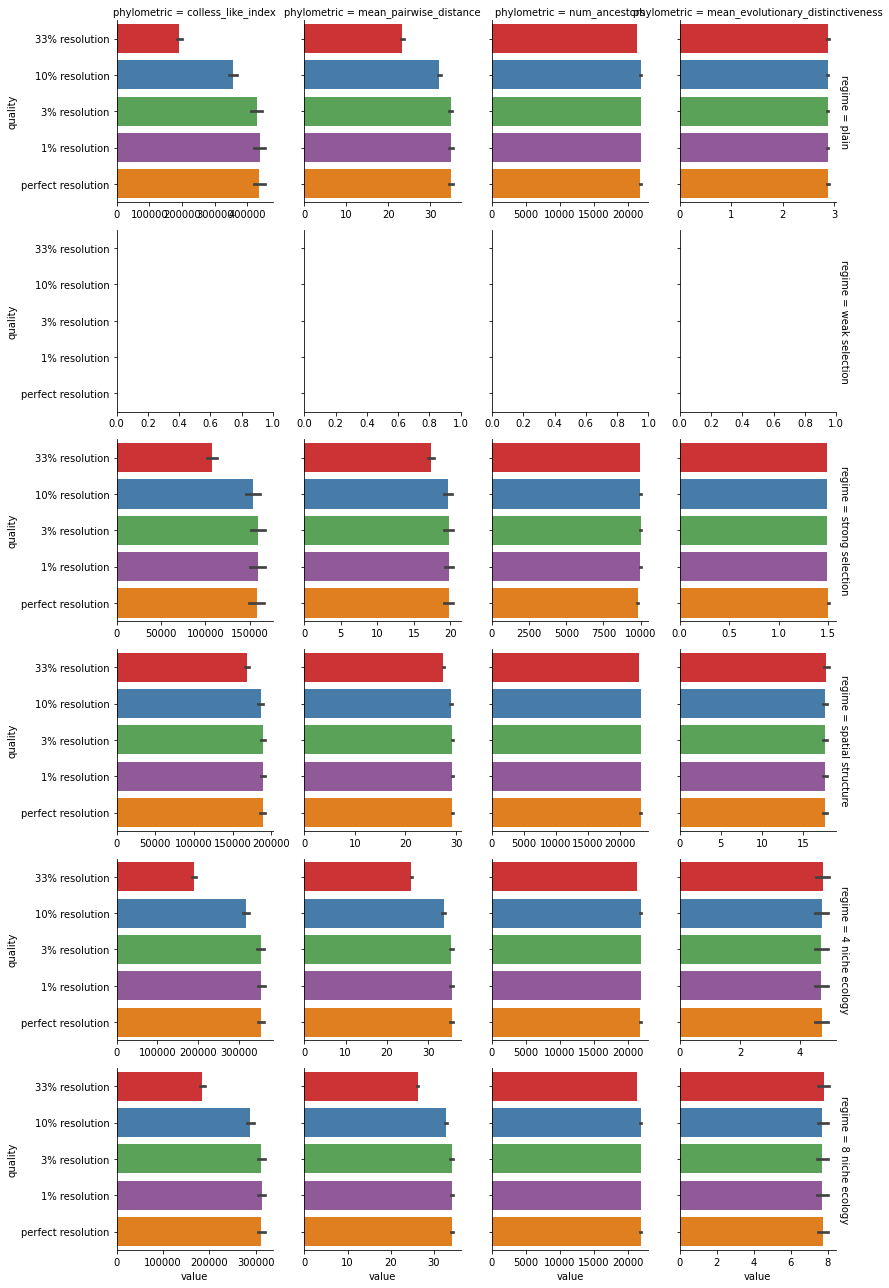

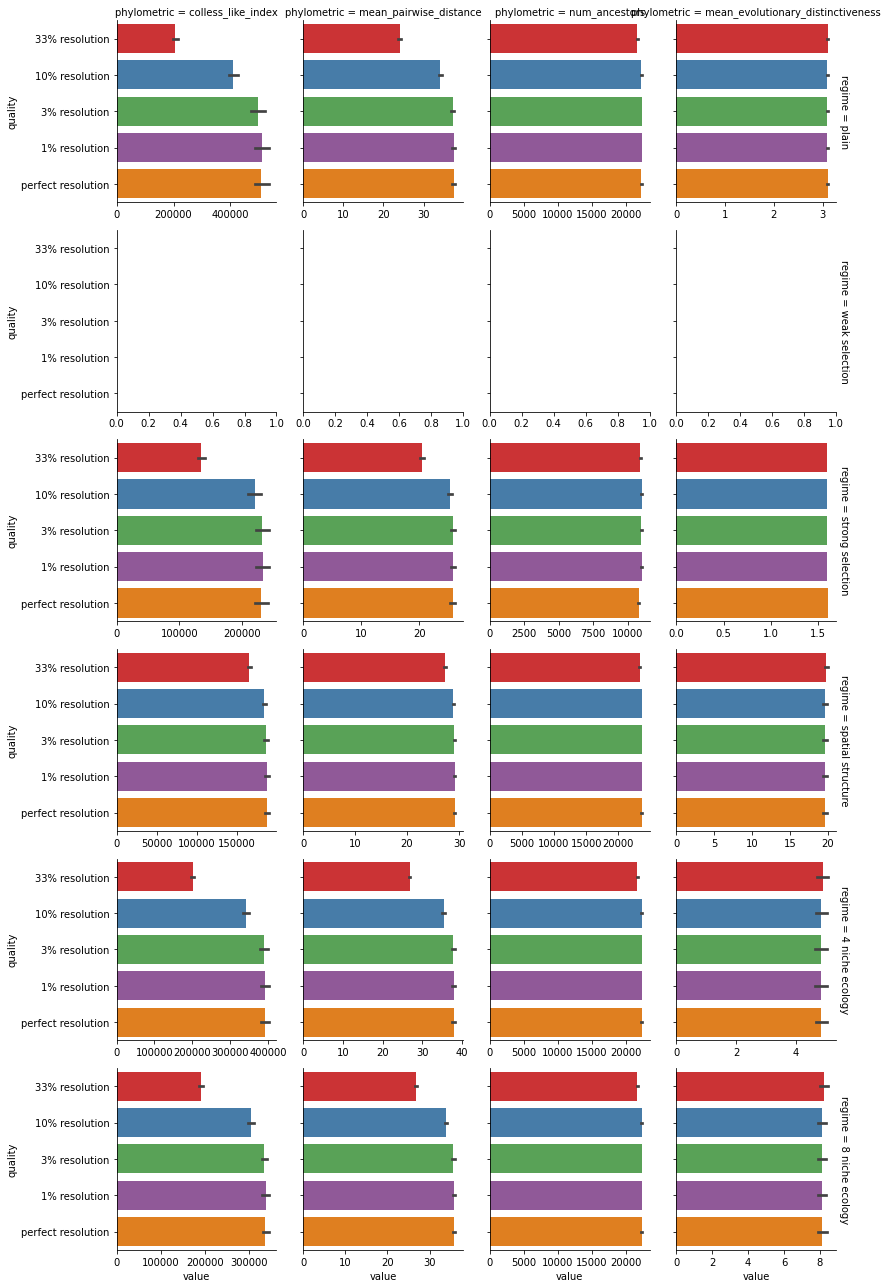

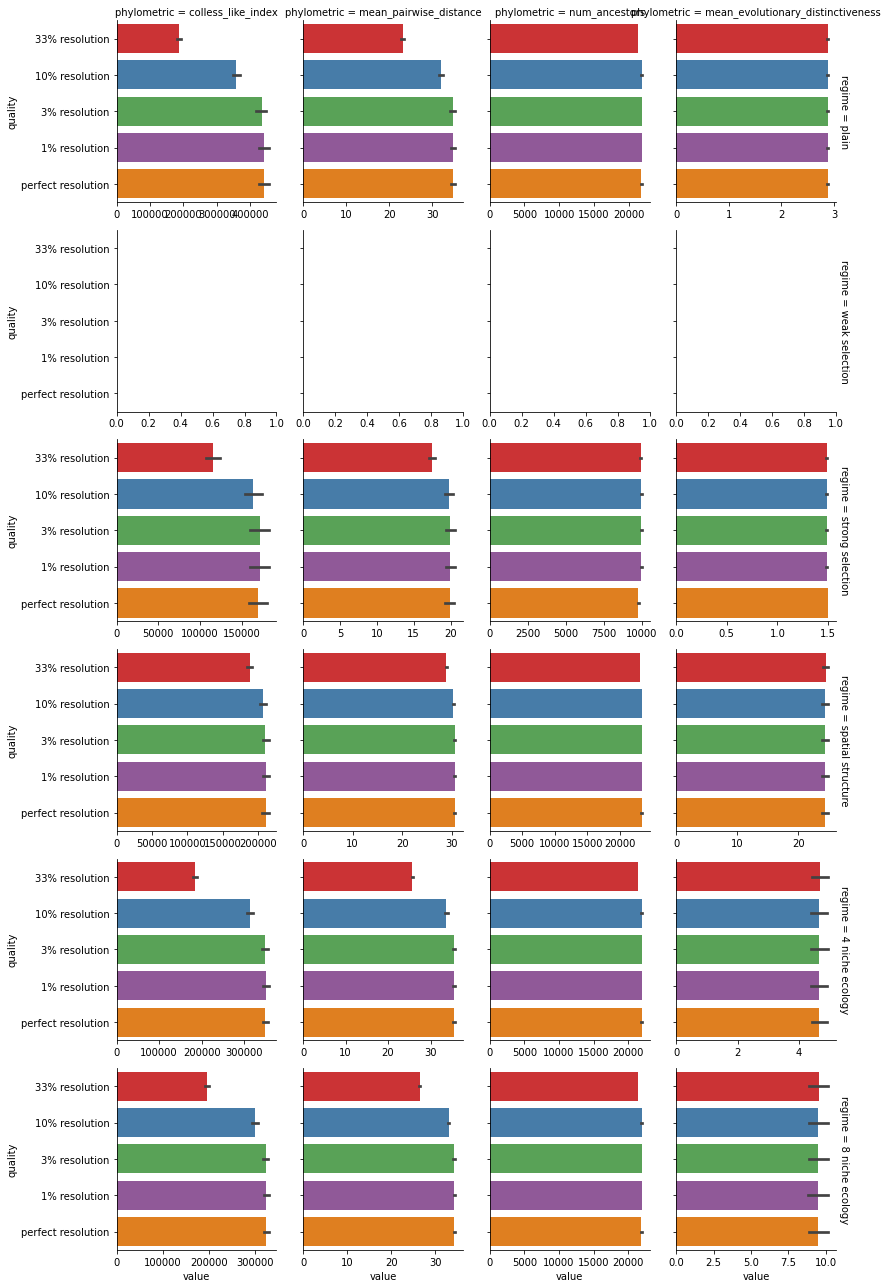

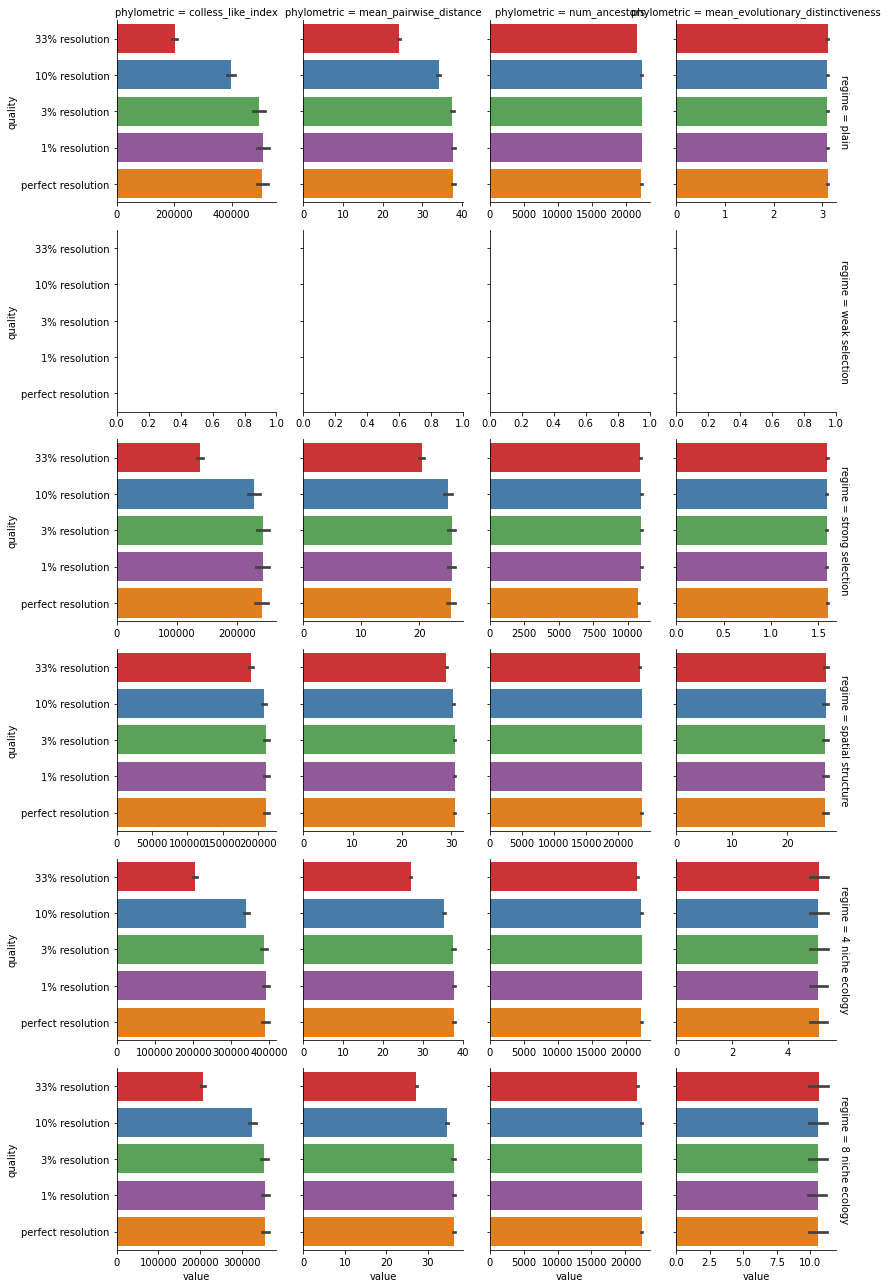

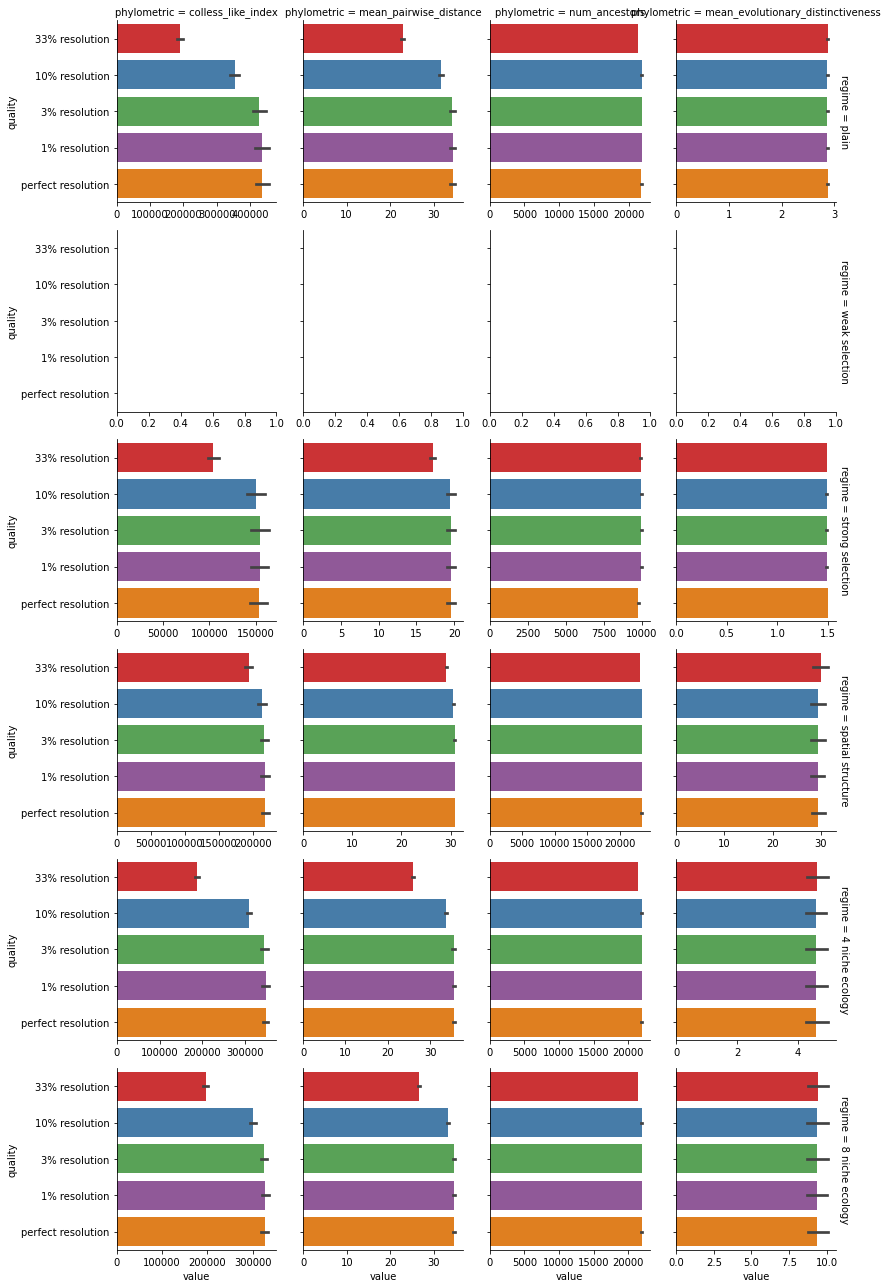

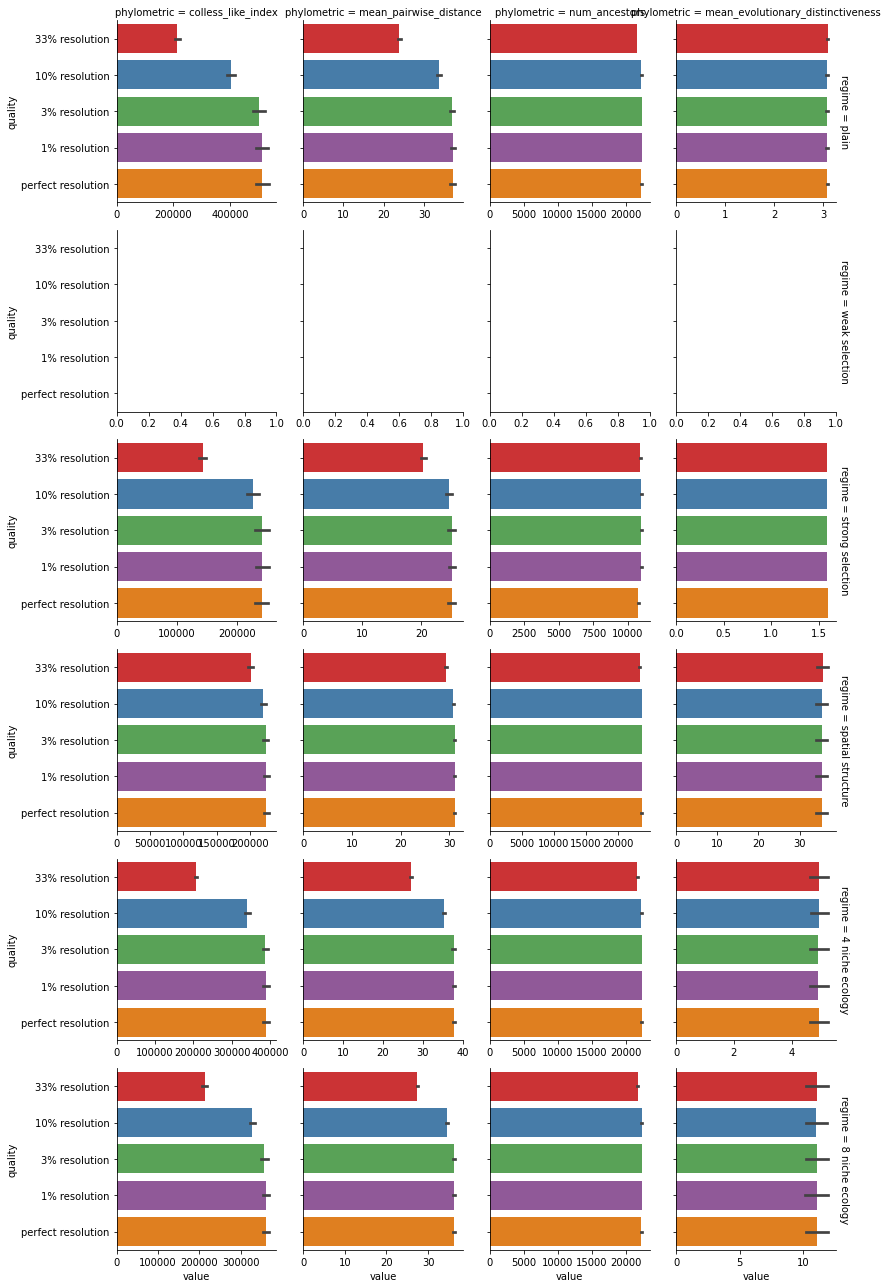

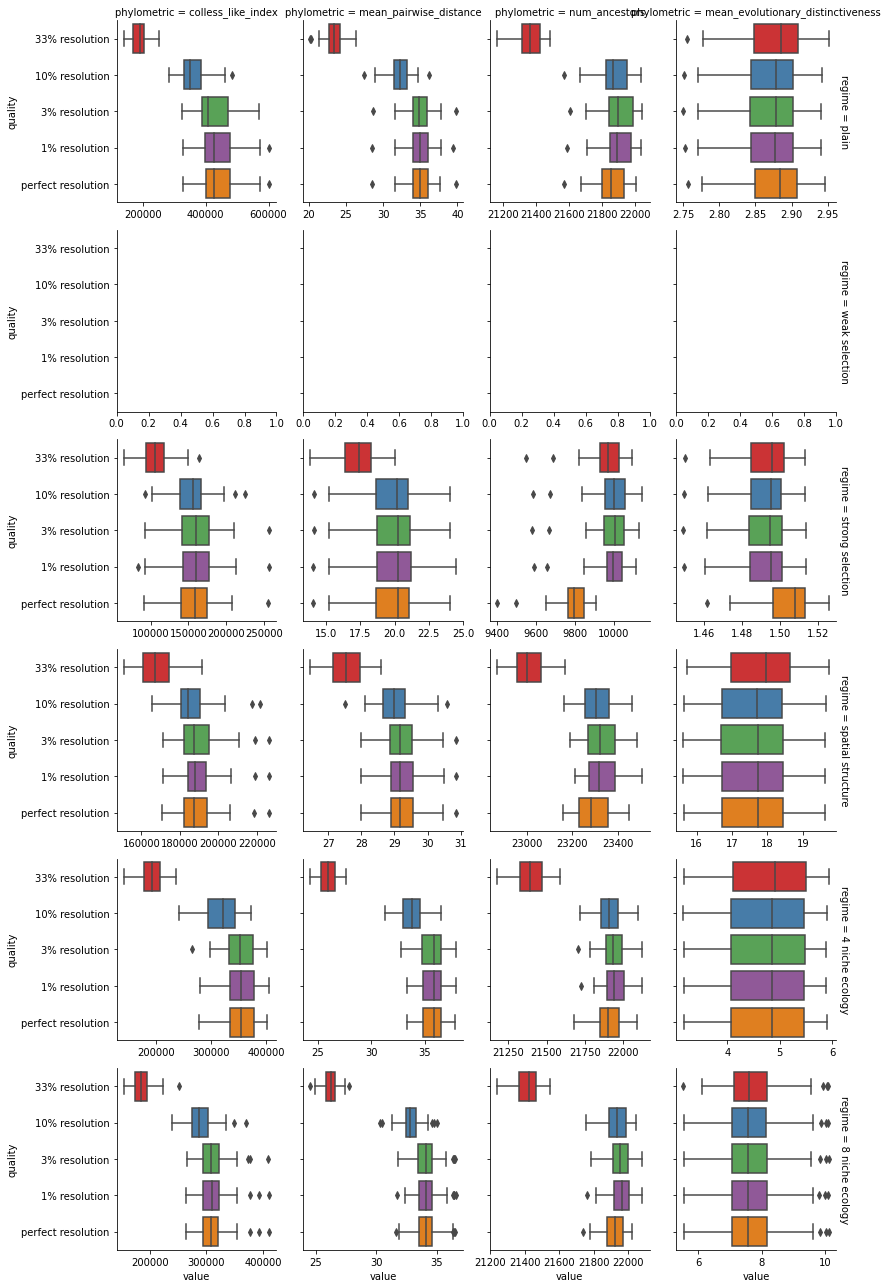

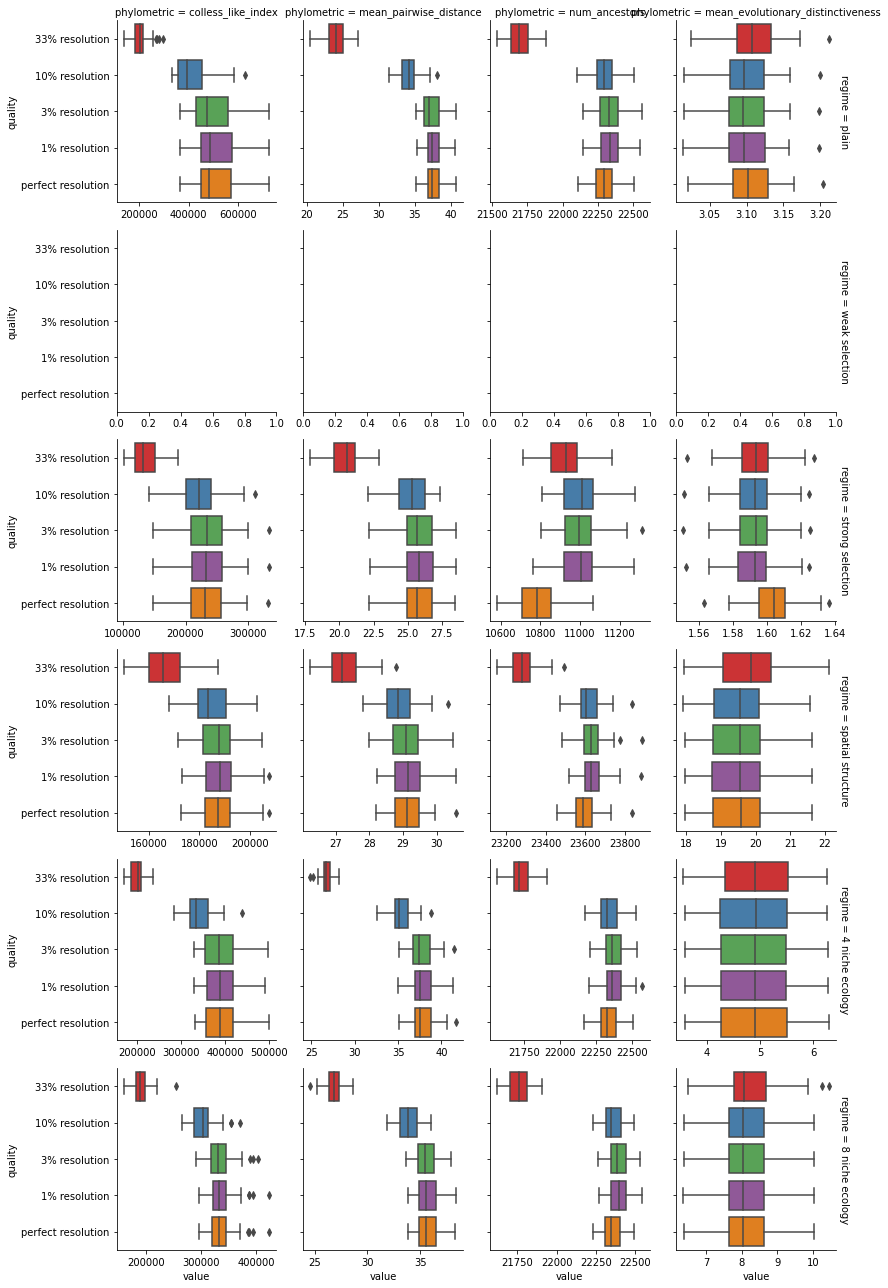

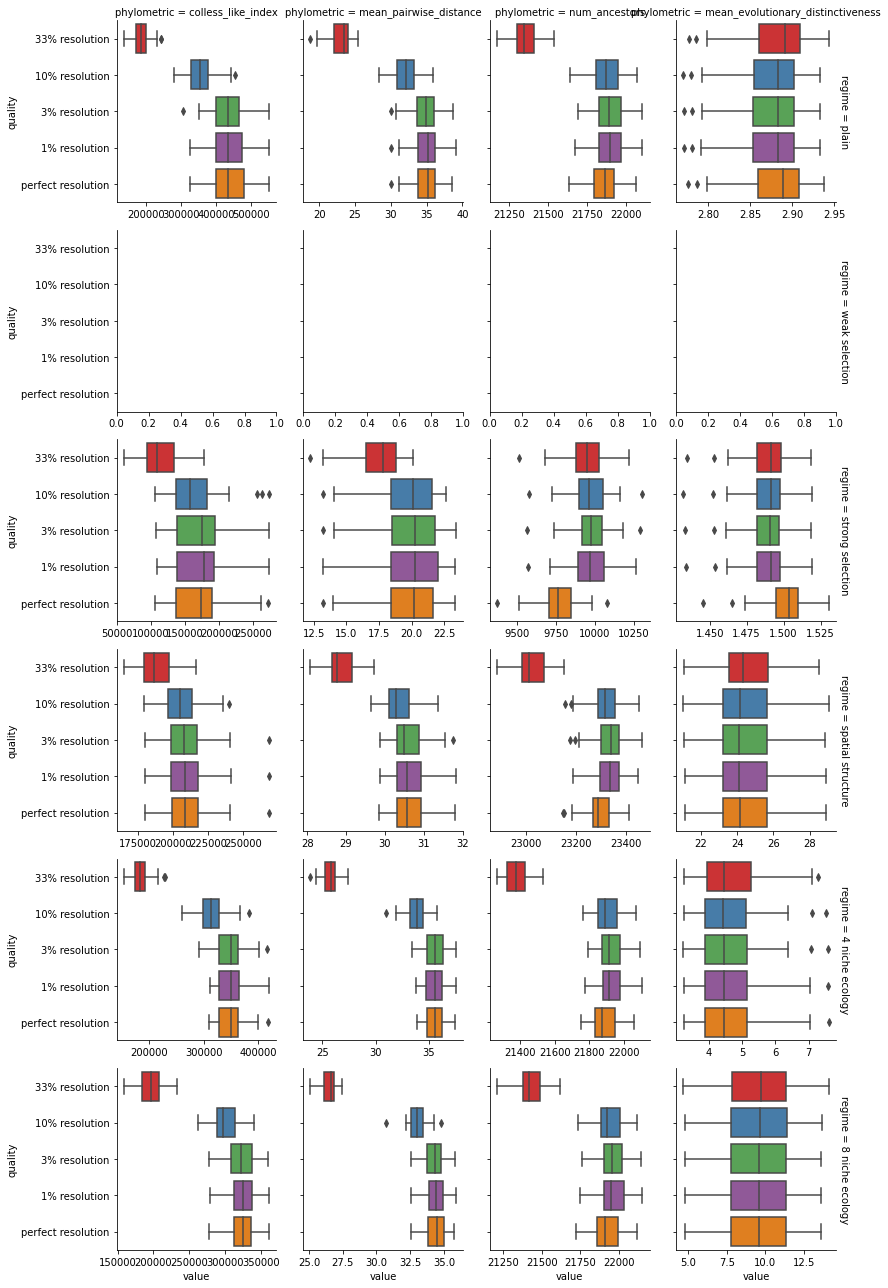

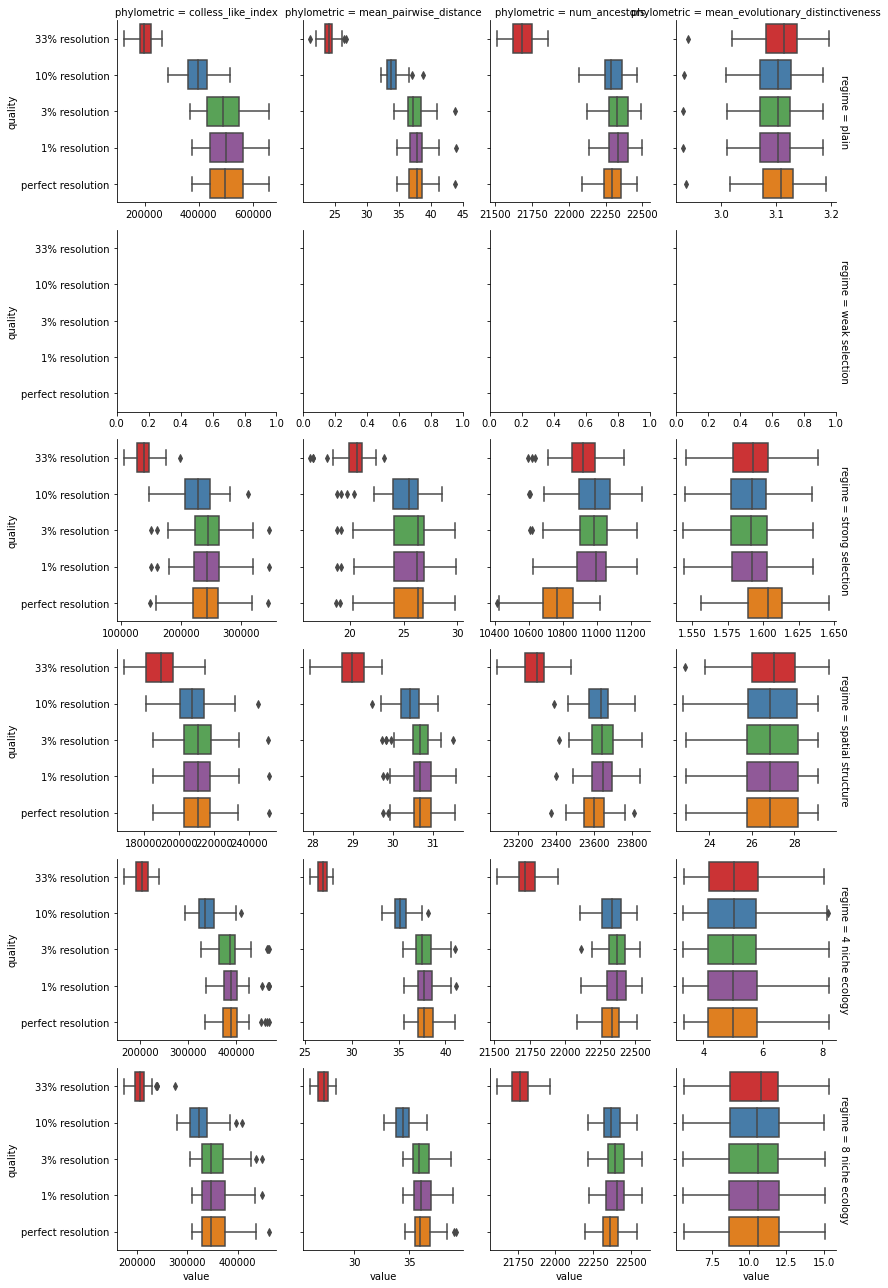

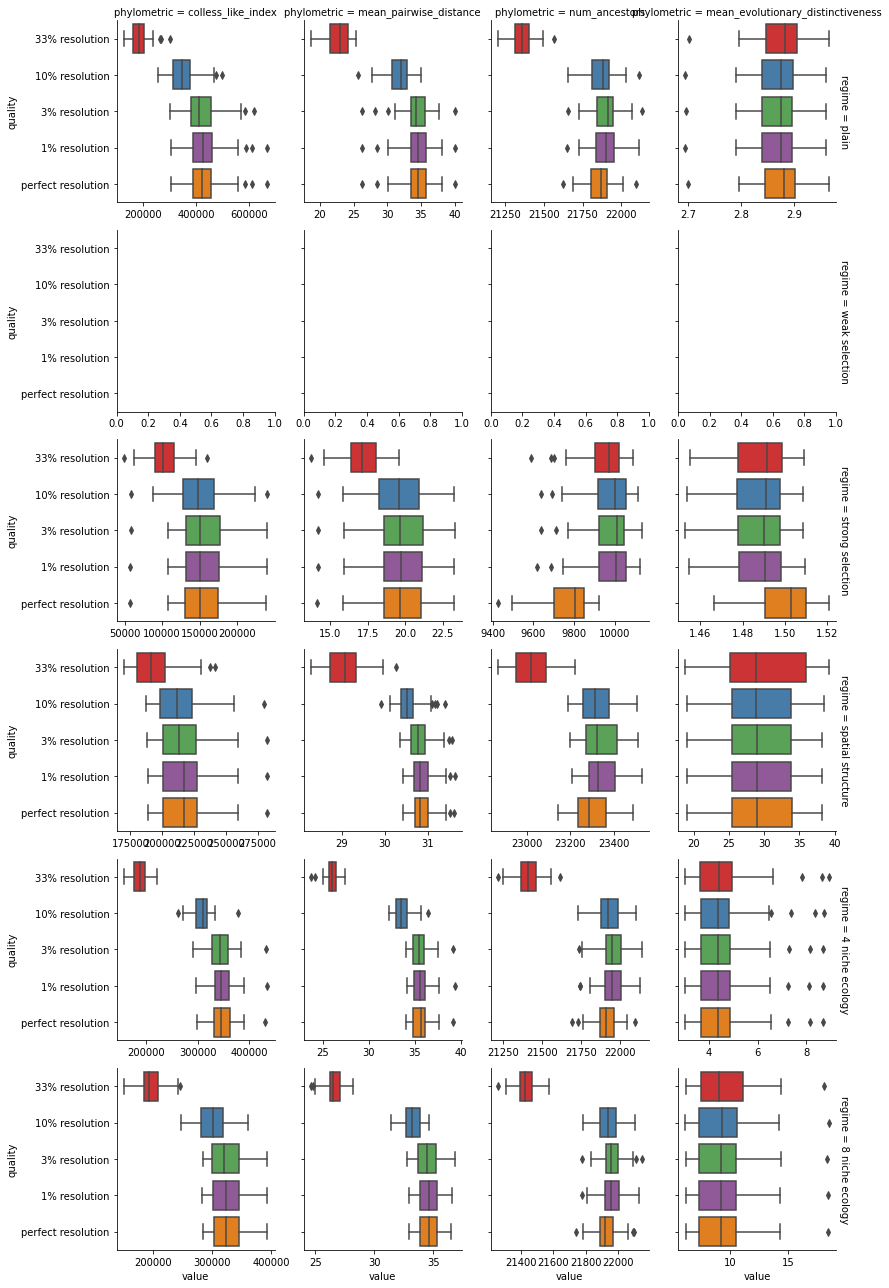

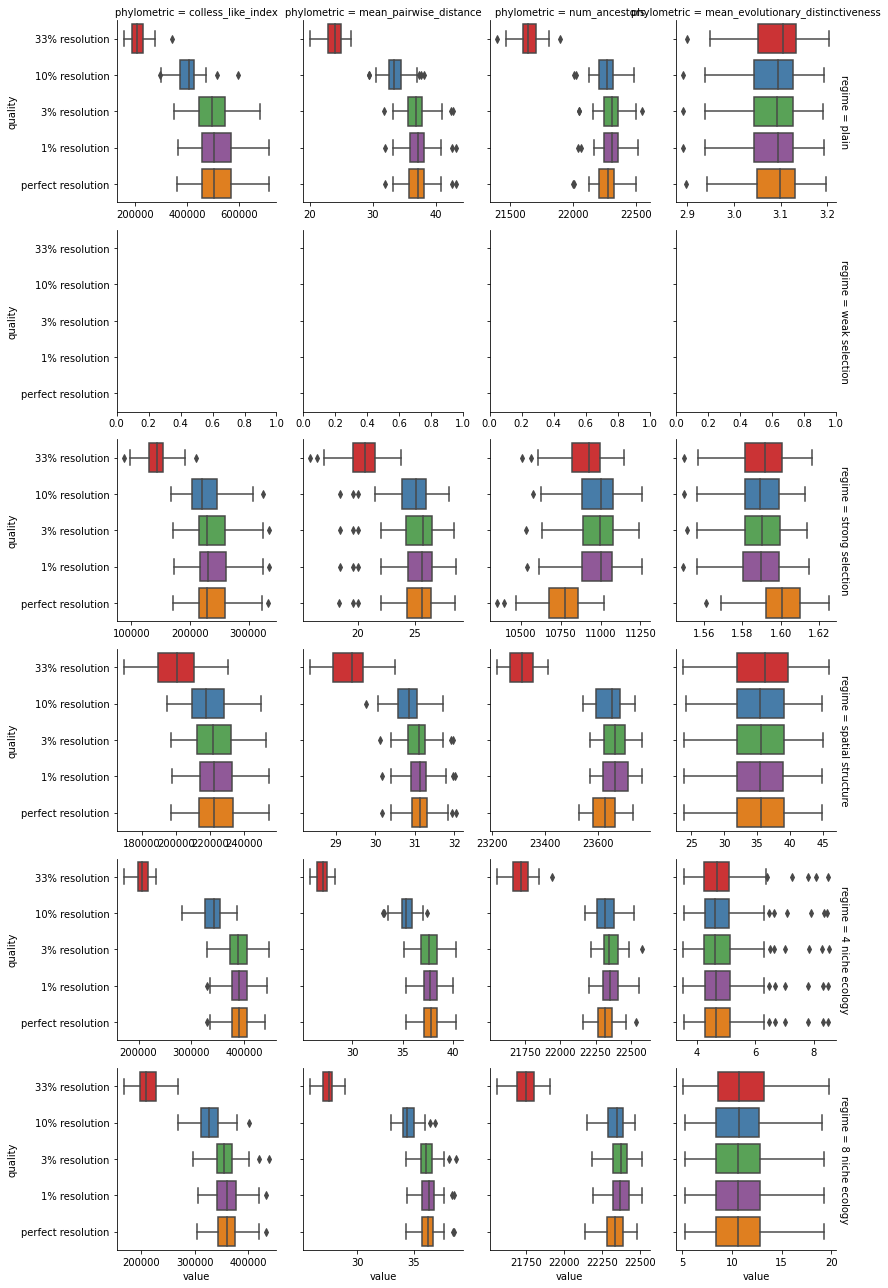

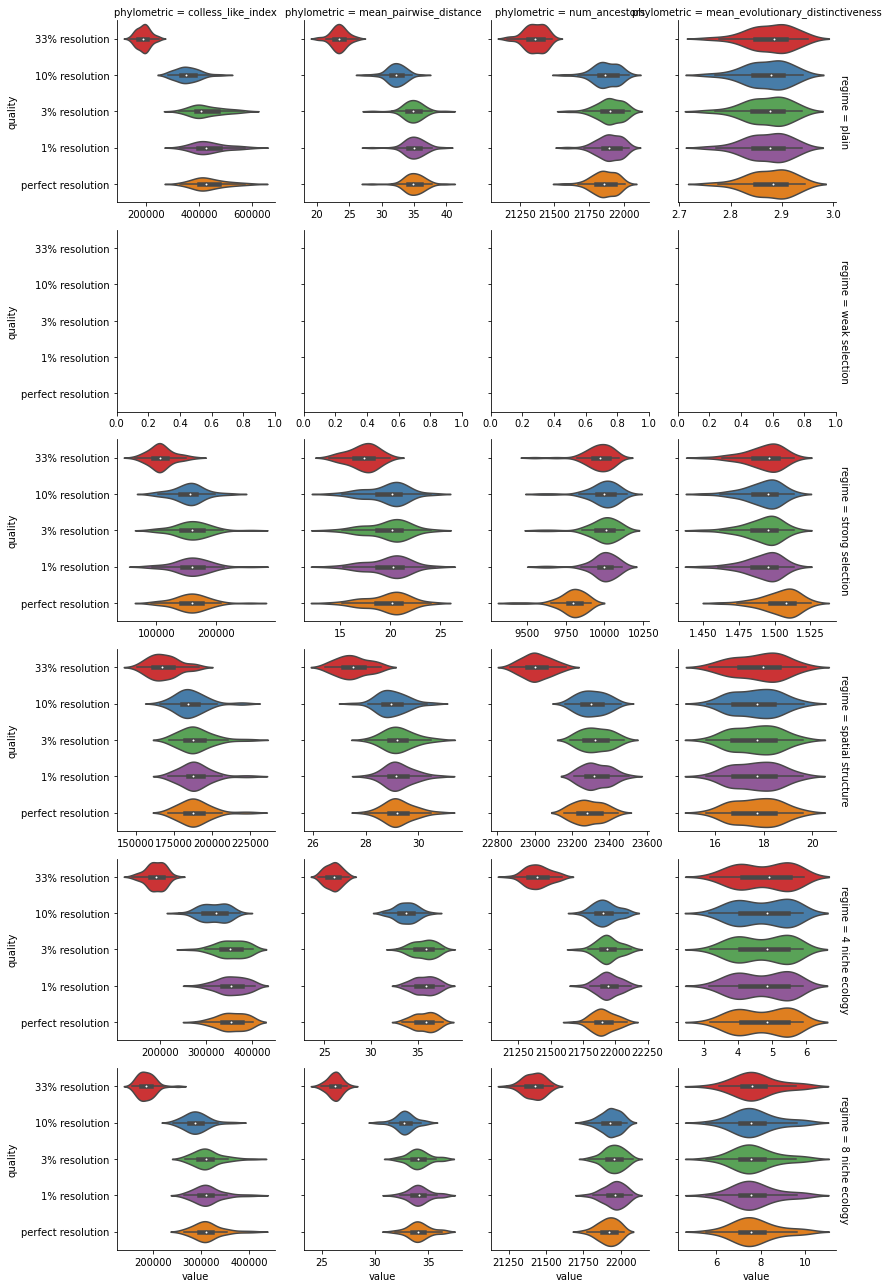

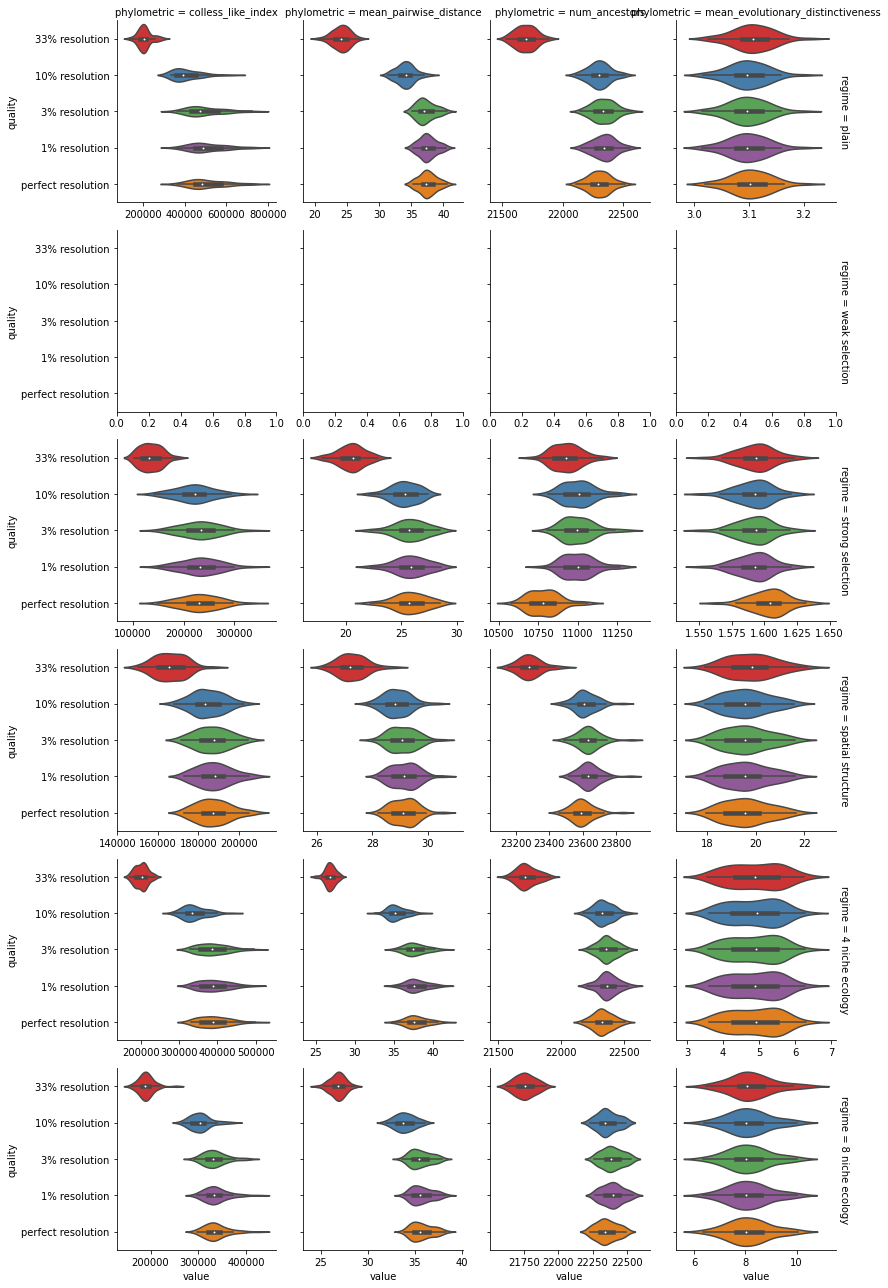

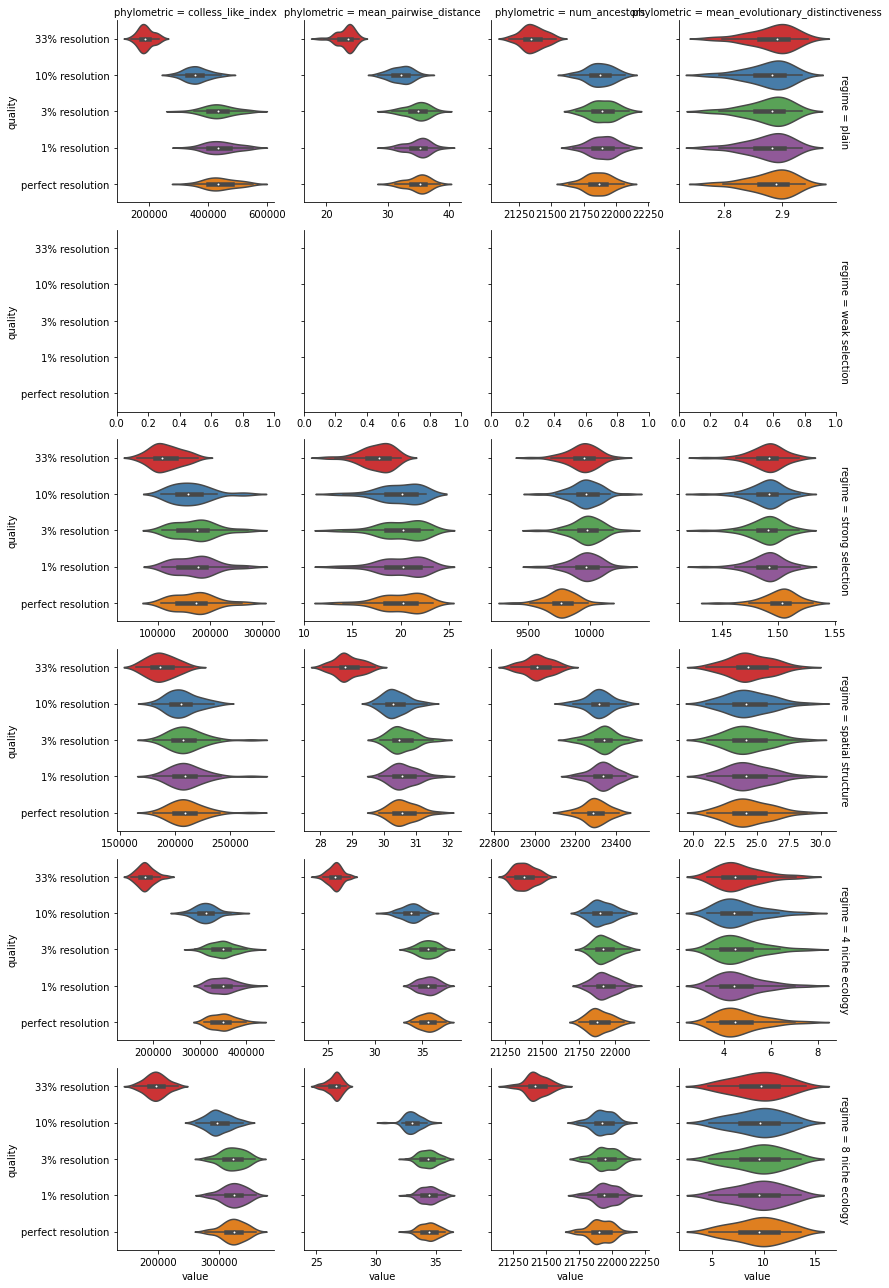

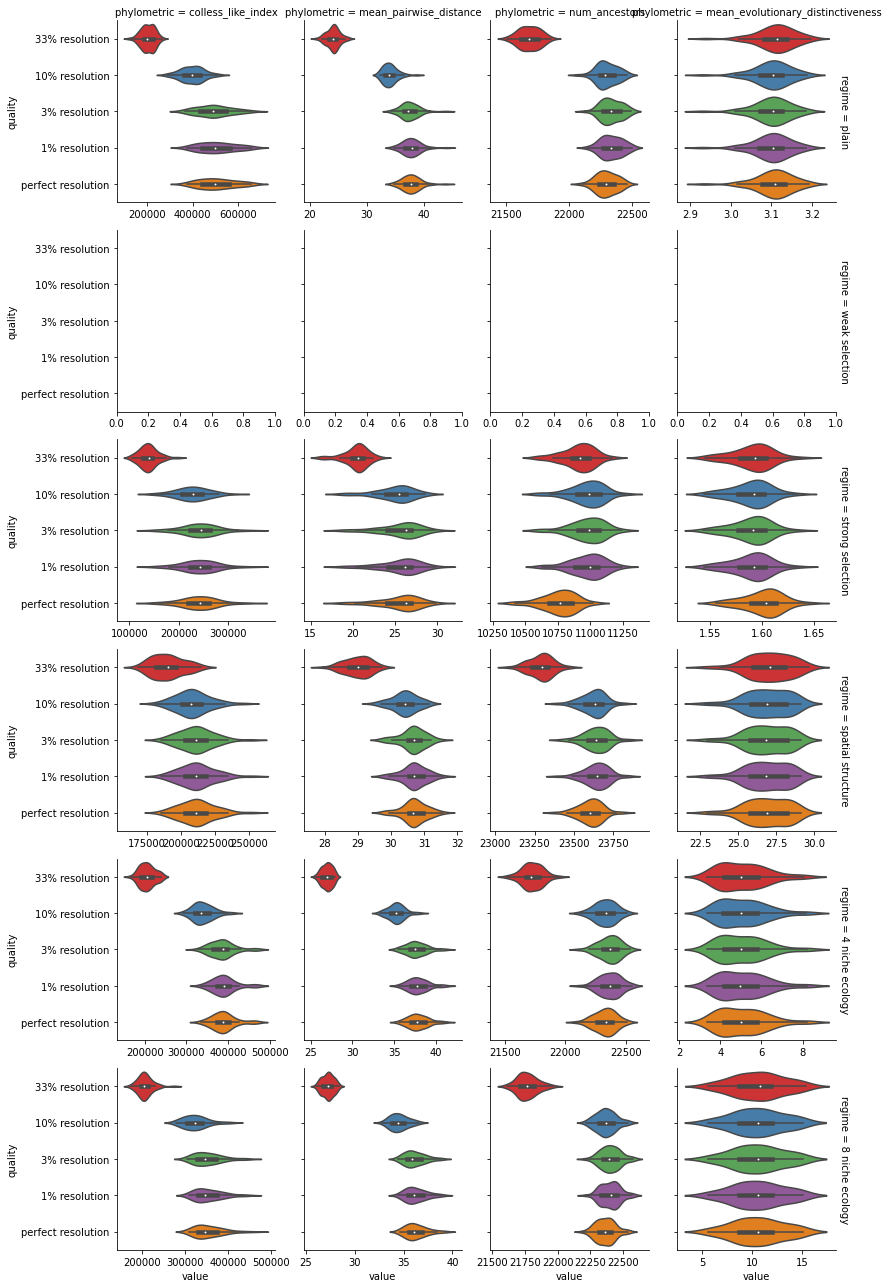

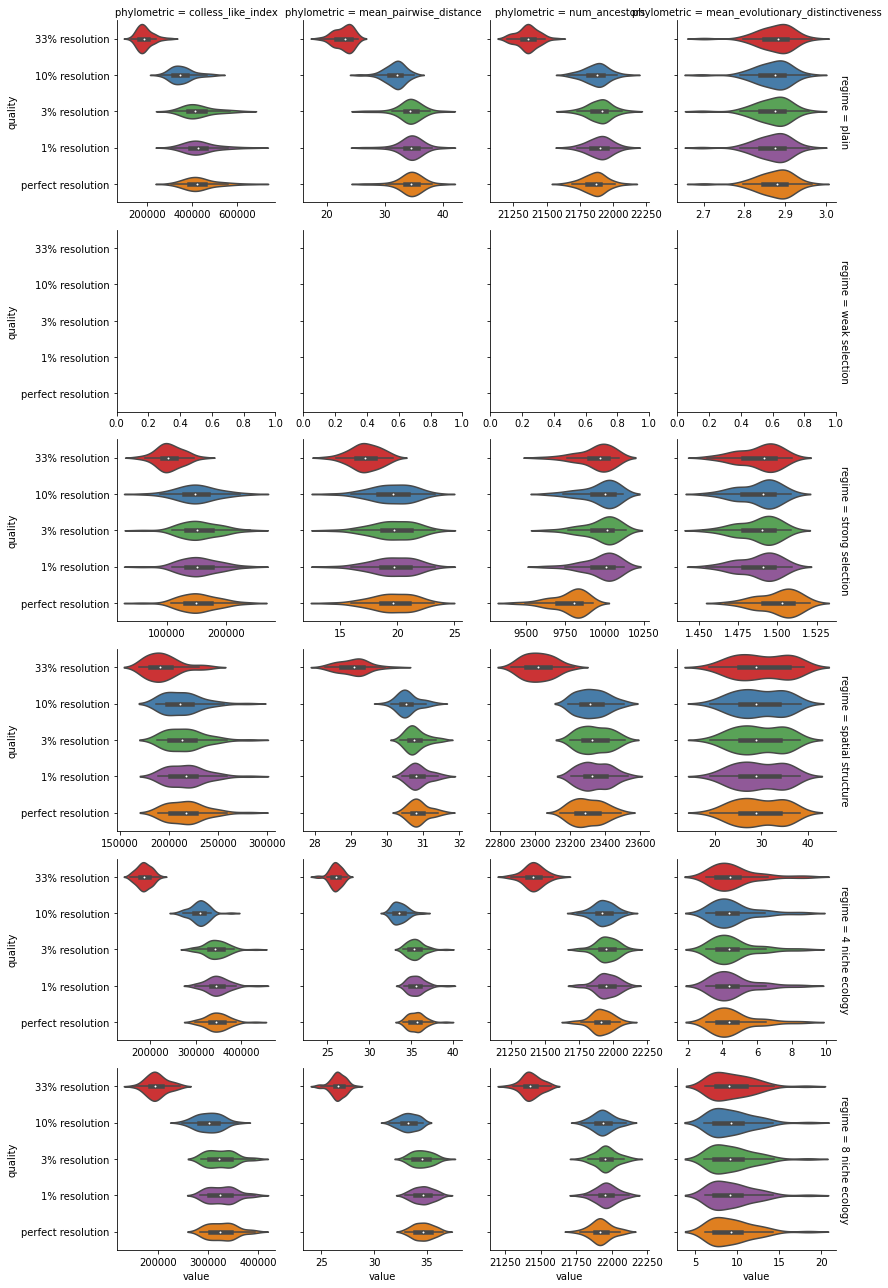

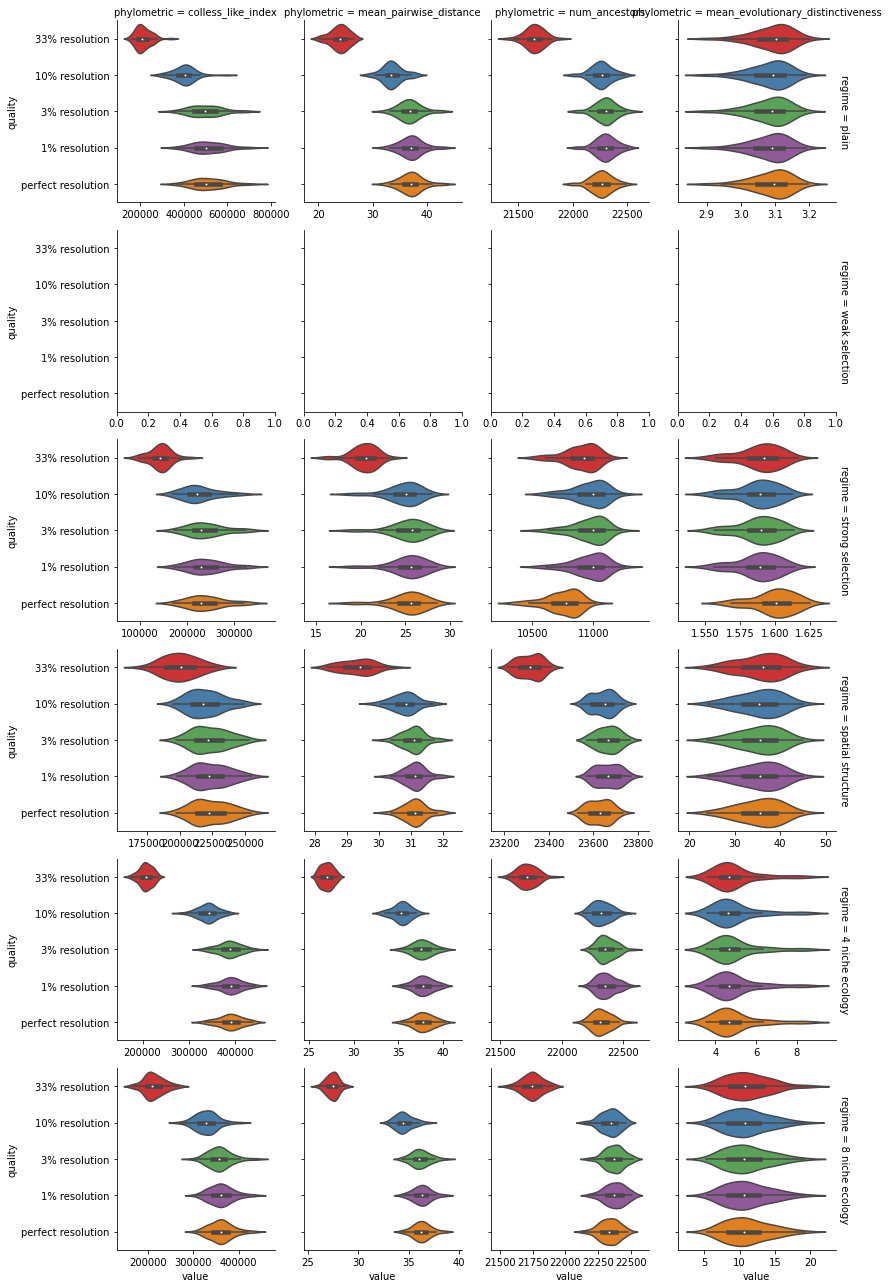

In [19]:
def make_do_plot(plotter):
    def do_plot(data, col, row, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            row=row,
            row_order=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "4 niche ecology",
                "8 niche ecology",
            ],
            sharex=False,
            margin_titles=True,
        )
        g.map(
            plotter,
            x,
            y,
            order=[
                "33% resolution",
                "10% resolution",
                "3% resolution",
                "1% resolution",
                "perfect resolution",
            ],
            palette=sns.color_palette("Set1", 5),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        row="regime",
        x="value",
        y="quality",
        teeplot_outattrs=dict(
            zip(sensitivity_analysis_variables, group),
        ),
    )
